# Experiment 6: α vs Position Analysis

**Question:** How does α change with token position during generation?

**Hypothesis:** α decreases with position due to:
1. LayerNorm washing out noise
2. Attention dilution over longer context

**Formula:** $T^*(t) = T_{base} \cdot \sqrt{1 + \alpha(t)}$

Using $T_{base} = 0.8$ (from GSM8K optimization)

In [1]:
# ============================================================
# IMPORTS & UTILITIES
# ============================================================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import re
from transformers import AutoModelForCausalLM, AutoTokenizer
from contextlib import contextmanager
from datasets import load_dataset

# ============================================================
# UTILITY FUNCTIONS
# ============================================================

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

@contextmanager
def activation_noise_context(model, noise_scale):
    """Add noise to activations throughout the model."""
    handles = []
    
    def make_hook(scale):
        def hook(module, args, kwargs):
            if len(args) > 0:
                x = args[0]
                noise = torch.randn_like(x) * scale * x.std()
                noisy_x = x + noise
                return (noisy_x,) + args[1:], kwargs
            return args, kwargs
        return hook
    
    try:
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                handle = module.register_forward_pre_hook(make_hook(noise_scale), with_kwargs=True)
                handles.append(handle)
        yield model, handles
    finally:
        for handle in handles:
            handle.remove()

@contextmanager
def weight_noise_context(model, noise_scale):
    """Add noise to model weights."""
    original_weights = {}
    
    try:
        for name, param in model.named_parameters():
            if 'weight' in name:
                original_weights[name] = param.data.clone()
                noise = torch.randn_like(param.data) * noise_scale * param.data.std()
                param.data.add_(noise)
        yield model, original_weights
    finally:
        for name, param in model.named_parameters():
            if name in original_weights:
                param.data.copy_(original_weights[name])

def compute_alpha(clean_logits, noisy_logits):
    """Compute α = σ²_noise / τ²_signal"""
    diff = noisy_logits - clean_logits
    tau_sq = clean_logits.var().item()
    sigma_sq = diff.var().item()
    alpha = sigma_sq / tau_sq if tau_sq > 0 else 0
    return alpha

print("Imports and utilities loaded!")

Imports and utilities loaded!


In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

SEED = 42
set_seed(SEED)

T_BASE = 0.8  # From GSM8K optimization (Experiment 5)

MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

print(f"T_base = {T_BASE}")
print(f"Loading {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map="auto"
)
model.eval()
print(f"Model loaded on {model.device}")

T_base = 0.8
Loading deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda:0


In [3]:
# ============================================================
# LOAD GSM8K
# ============================================================

gsm8k = load_dataset('gsm8k', 'main', split='test')
print(f"GSM8K loaded: {len(gsm8k)} examples")

# Prepare prompts
num_examples = 5  # Use 5 for position analysis (generates many tokens)
test_examples = [gsm8k[i] for i in range(num_examples)]

gsm_prompts = []
for ex in test_examples:
    messages = [{"role": "user", "content": f"Solve this step by step:\n{ex['question']}"}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    gsm_prompts.append(prompt)

print(f"Prepared {len(gsm_prompts)} prompts")

GSM8K loaded: 1319 examples
Prepared 5 prompts


## 6a: Measure α per Token Position

Using teacher forcing, measure α at each position during generation.

In [4]:
def measure_alpha_per_position(model, tokenizer, prompt, noise_ctx_fn, noise_scale, 
                                max_tokens=100, num_samples=3):
    """
    Measure α at each token position using teacher forcing.
    """
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    input_ids = inputs.input_ids.clone()
    
    # First generate clean sequence
    clean_logits_seq = []
    clean_tokens = []
    
    with torch.no_grad():
        for _ in range(max_tokens):
            outputs = model(input_ids)
            logits = outputs.logits[0, -1, :].float()
            clean_logits_seq.append(logits.cpu())
            token = logits.argmax().item()
            clean_tokens.append(token)
            input_ids = torch.cat([input_ids, torch.tensor([[token]]).to(model.device)], dim=1)
            
            if token == tokenizer.eos_token_id:
                break
    
    actual_tokens = len(clean_tokens)
    
    # Measure α at each position with noise
    alpha_per_pos = [[] for _ in range(actual_tokens)]
    
    for _ in range(num_samples):
        with noise_ctx_fn(model, noise_scale) as (noisy_model, _):
            input_ids = inputs.input_ids.clone()
            
            for t in range(actual_tokens):
                with torch.no_grad():
                    outputs = noisy_model(input_ids)
                    noisy_logits = outputs.logits[0, -1, :].float().cpu()
                
                alpha = compute_alpha(clean_logits_seq[t], noisy_logits)
                alpha_per_pos[t].append(alpha)
                
                # Teacher forcing: use clean token
                input_ids = torch.cat([input_ids, torch.tensor([[clean_tokens[t]]]).to(model.device)], dim=1)
    
    return [np.mean(alphas) if alphas else 0 for alphas in alpha_per_pos]

In [5]:
# ============================================================
# MEASURE α PER POSITION
# ============================================================

noise_scale = 0.05
max_tokens = 150

print(f"Measuring α per position (noise={noise_scale}, max_tokens={max_tokens})...")
print("="*60)

all_alpha_activation = []
all_alpha_weight = []

for i, prompt in enumerate(gsm_prompts):
    print(f"\nPrompt {i+1}/{len(gsm_prompts)}...")
    
    print("  Activation noise...")
    alpha_act = measure_alpha_per_position(
        model, tokenizer, prompt, activation_noise_context, noise_scale, max_tokens
    )
    all_alpha_activation.append(alpha_act)
    
    print("  Weight noise...")
    alpha_weight = measure_alpha_per_position(
        model, tokenizer, prompt, weight_noise_context, noise_scale, max_tokens
    )
    all_alpha_weight.append(alpha_weight)

print("\nDone!")

Measuring α per position (noise=0.05, max_tokens=150)...

Prompt 1/5...
  Activation noise...
  Weight noise...

Prompt 2/5...
  Activation noise...
  Weight noise...

Prompt 3/5...
  Activation noise...
  Weight noise...

Prompt 4/5...
  Activation noise...
  Weight noise...

Prompt 5/5...
  Activation noise...
  Weight noise...

Done!


In [6]:
# ============================================================
# AGGREGATE RESULTS
# ============================================================

# Find min length across all prompts
min_len = min(len(a) for a in all_alpha_activation)
print(f"Min sequence length: {min_len}")

# Truncate to min length and average
alpha_activation = np.mean([a[:min_len] for a in all_alpha_activation], axis=0)
alpha_weight = np.mean([a[:min_len] for a in all_alpha_weight], axis=0)

print(f"Activation α: first={alpha_activation[0]:.4f}, last={alpha_activation[-1]:.4f}")
print(f"Weight α: first={alpha_weight[0]:.4f}, last={alpha_weight[-1]:.4f}")

Min sequence length: 150
Activation α: first=0.6204, last=0.0822
Weight α: first=0.0413, last=0.0195


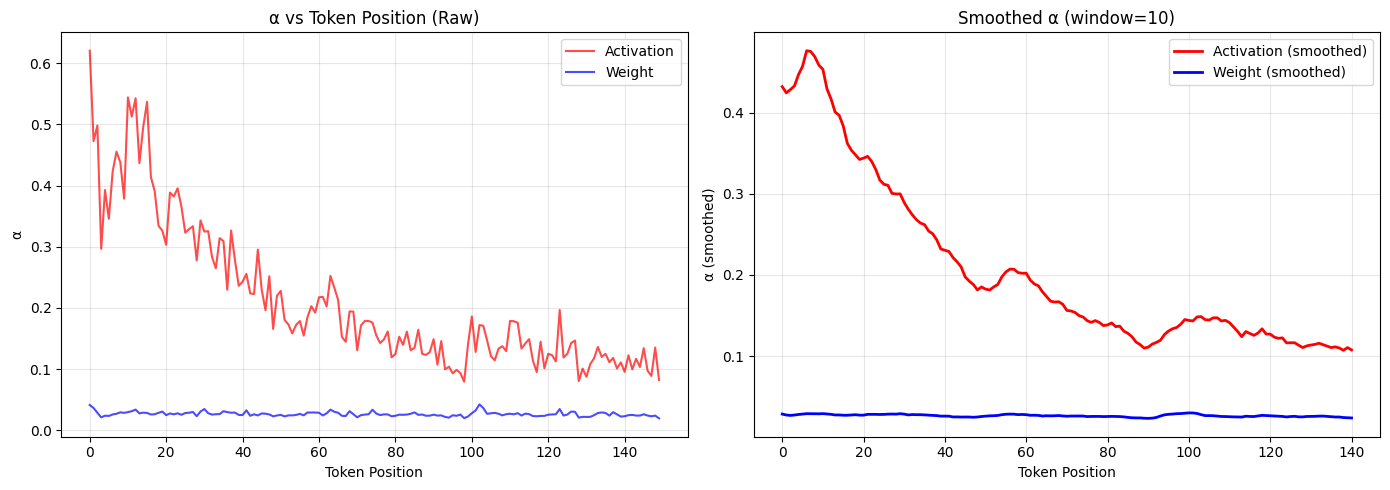


STATISTICS

Activation noise:
  First 10: mean α = 0.4321
  Last 10:  mean α = 0.1076
  Ratio: 4.0x decrease

Weight noise:
  First 10: mean α = 0.0285
  Last 10:  mean α = 0.0237
  Ratio: 1.2x decrease


In [7]:
# ============================================================
# PLOT α VS POSITION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

positions = range(len(alpha_activation))

# Left: Raw values
ax1 = axes[0]
ax1.plot(positions, alpha_activation, 'r-', alpha=0.7, linewidth=1.5, label='Activation')
ax1.plot(positions, alpha_weight, 'b-', alpha=0.7, linewidth=1.5, label='Weight')
ax1.set_xlabel('Token Position')
ax1.set_ylabel('α')
ax1.set_title('α vs Token Position (Raw)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Smoothed
window = 10
act_smooth = np.convolve(alpha_activation, np.ones(window)/window, mode='valid')
weight_smooth = np.convolve(alpha_weight, np.ones(window)/window, mode='valid')

ax2 = axes[1]
ax2.plot(range(len(act_smooth)), act_smooth, 'r-', linewidth=2, label='Activation (smoothed)')
ax2.plot(range(len(weight_smooth)), weight_smooth, 'b-', linewidth=2, label='Weight (smoothed)')
ax2.set_xlabel('Token Position')
ax2.set_ylabel('α (smoothed)')
ax2.set_title(f'Smoothed α (window={window})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('alpha_vs_position.png', dpi=150)
plt.show()

# Stats
print("\n" + "="*60)
print("STATISTICS")
print("="*60)
print(f"\nActivation noise:")
print(f"  First 10: mean α = {np.mean(alpha_activation[:10]):.4f}")
print(f"  Last 10:  mean α = {np.mean(alpha_activation[-10:]):.4f}")
ratio_act = np.mean(alpha_activation[:10]) / np.mean(alpha_activation[-10:]) if np.mean(alpha_activation[-10:]) > 0 else float('inf')
print(f"  Ratio: {ratio_act:.1f}x decrease")

print(f"\nWeight noise:")
print(f"  First 10: mean α = {np.mean(alpha_weight[:10]):.4f}")
print(f"  Last 10:  mean α = {np.mean(alpha_weight[-10:]):.4f}")
ratio_weight = np.mean(alpha_weight[:10]) / np.mean(alpha_weight[-10:]) if np.mean(alpha_weight[-10:]) > 0 else float('inf')
print(f"  Ratio: {ratio_weight:.1f}x decrease")

## 6b: Compute T*(t) per Position

Using $T^*(t) = T_{base} \cdot \sqrt{1 + \alpha(t)}$

In [8]:
# ============================================================
# COMPUTE T* PER POSITION
# ============================================================

t_star_activation = [T_BASE * np.sqrt(1 + a) for a in alpha_activation]
t_star_weight = [T_BASE * np.sqrt(1 + a) for a in alpha_weight]

# Constant T* using mean α
t_star_const_act = T_BASE * np.sqrt(1 + np.mean(alpha_activation))
t_star_const_weight = T_BASE * np.sqrt(1 + np.mean(alpha_weight))

print(f"T_base = {T_BASE}")
print(f"\nActivation noise:")
print(f"  T*(t) range: {min(t_star_activation):.3f} to {max(t_star_activation):.3f}")
print(f"  Constant T* (mean α): {t_star_const_act:.3f}")
print(f"\nWeight noise:")
print(f"  T*(t) range: {min(t_star_weight):.3f} to {max(t_star_weight):.3f}")
print(f"  Constant T* (mean α): {t_star_const_weight:.3f}")

T_base = 0.8

Activation noise:
  T*(t) range: 0.831 to 1.018
  Constant T* (mean α): 0.881

Weight noise:
  T*(t) range: 0.808 to 0.817
  Constant T* (mean α): 0.811


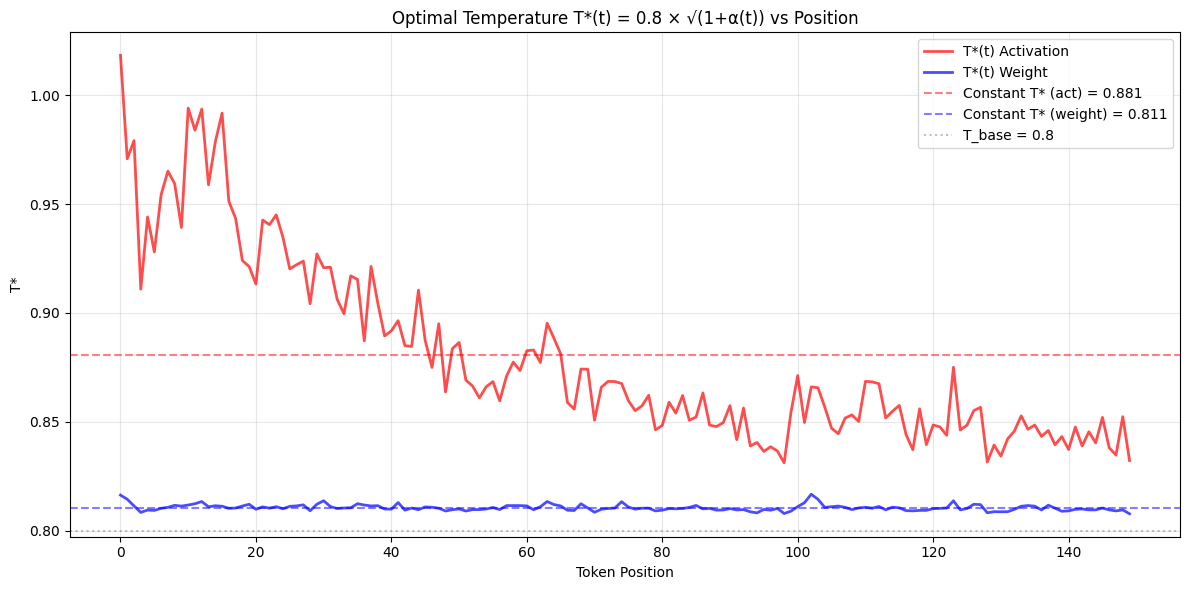

In [9]:
# ============================================================
# PLOT T* VS POSITION
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(positions, t_star_activation, 'r-', linewidth=2, alpha=0.7, label='T*(t) Activation')
ax.plot(positions, t_star_weight, 'b-', linewidth=2, alpha=0.7, label='T*(t) Weight')

ax.axhline(y=t_star_const_act, color='red', linestyle='--', alpha=0.5, 
           label=f'Constant T* (act) = {t_star_const_act:.3f}')
ax.axhline(y=t_star_const_weight, color='blue', linestyle='--', alpha=0.5,
           label=f'Constant T* (weight) = {t_star_const_weight:.3f}')
ax.axhline(y=T_BASE, color='gray', linestyle=':', alpha=0.5, label=f'T_base = {T_BASE}')

ax.set_xlabel('Token Position')
ax.set_ylabel('T*')
ax.set_title(f'Optimal Temperature T*(t) = {T_BASE} × √(1+α(t)) vs Position')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('t_star_vs_position.png', dpi=150)
plt.show()

## 6c: Compare Constant vs Dynamic T*

What's the error from using constant T* instead of dynamic T*(t)?

In [10]:
# ============================================================
# COMPARE CONSTANT VS DYNAMIC T*
# ============================================================

print("Comparing constant vs dynamic T* for activation noise:")
print("="*60)

# Error metrics
errors_const_mean = [abs(t - t_star_const_act) for t in t_star_activation]
errors_const_tbase = [abs(t - T_BASE) for t in t_star_activation]

print(f"\nUsing constant T* = {t_star_const_act:.3f} (mean α):")
print(f"  Mean absolute error: {np.mean(errors_const_mean):.4f}")
print(f"  Max error: {max(errors_const_mean):.4f}")

print(f"\nUsing T = {T_BASE} (T_base, ignoring noise):")
print(f"  Mean absolute error: {np.mean(errors_const_tbase):.4f}")
print(f"  Max error: {max(errors_const_tbase):.4f}")

# By position segment
segments = [
    ('First 20', 0, 20),
    ('Middle', len(t_star_activation)//2 - 10, len(t_star_activation)//2 + 10),
    ('Last 20', -20, None)
]

print(f"\nError by position (using constant T* = {t_star_const_act:.3f}):")
for name, start, end in segments:
    segment_t_star = t_star_activation[start:end]
    segment_errors = [abs(t - t_star_const_act) for t in segment_t_star]
    print(f"  {name}: mean error = {np.mean(segment_errors):.4f}, mean T*(t) = {np.mean(segment_t_star):.3f}")

Comparing constant vs dynamic T* for activation noise:

Using constant T* = 0.881 (mean α):
  Mean absolute error: 0.0339
  Max error: 0.1378

Using T = 0.8 (T_base, ignoring noise):
  Mean absolute error: 0.0796
  Max error: 0.2184

Error by position (using constant T* = 0.881):
  First 20: mean error = 0.0800, mean T*(t) = 0.961
  Middle: mean error = 0.0196, mean T*(t) = 0.861
  Last 20: mean error = 0.0375, mean T*(t) = 0.843


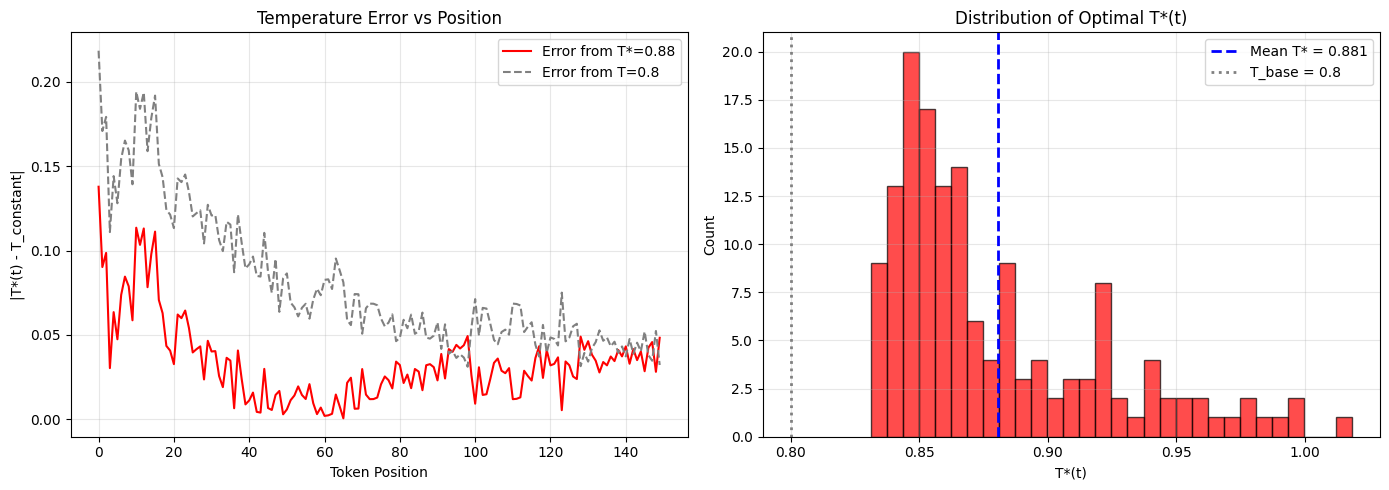

In [11]:
# ============================================================
# PLOT ERROR ANALYSIS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Error vs position
ax1 = axes[0]
ax1.plot(positions, errors_const_mean, 'r-', linewidth=1.5, label=f'Error from T*={t_star_const_act:.2f}')
ax1.plot(positions, errors_const_tbase, 'gray', linestyle='--', linewidth=1.5, label=f'Error from T={T_BASE}')
ax1.set_xlabel('Token Position')
ax1.set_ylabel('|T*(t) - T_constant|')
ax1.set_title('Temperature Error vs Position')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Histogram of T*(t)
ax2 = axes[1]
ax2.hist(t_star_activation, bins=30, alpha=0.7, color='red', edgecolor='black')
ax2.axvline(x=t_star_const_act, color='blue', linestyle='--', linewidth=2, label=f'Mean T* = {t_star_const_act:.3f}')
ax2.axvline(x=T_BASE, color='gray', linestyle=':', linewidth=2, label=f'T_base = {T_BASE}')
ax2.set_xlabel('T*(t)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Optimal T*(t)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('t_star_error_analysis.png', dpi=150)
plt.show()

In [12]:
# ============================================================
# FIT α(t) FUNCTION
# ============================================================

from scipy.optimize import curve_fit

# Define candidate functions
def power_law(t, a, b, c):
    """α(t) = a / (t + b)^c"""
    return a / (t + b + 1e-6)**c

def exponential_decay(t, a, b, c):
    """α(t) = a * exp(-b*t) + c"""
    return a * np.exp(-b * t) + c

def inverse_linear(t, a, b):
    """α(t) = a / (t + b)"""
    return a / (t + b + 1e-6)

def inverse_sqrt(t, a, b, c):
    """α(t) = a / sqrt(t + b) + c"""
    return a / np.sqrt(t + b + 1e-6) + c

# Fit activation noise
positions_arr = np.array(range(len(alpha_activation)))
alpha_arr = np.array(alpha_activation)

fits = {}

# Try each function
try:
    popt, _ = curve_fit(power_law, positions_arr, alpha_arr, p0=[0.5, 1, 0.5], maxfev=5000)
    pred = power_law(positions_arr, *popt)
    mse = np.mean((alpha_arr - pred)**2)
    fits['power_law'] = {'params': popt, 'mse': mse, 'func': power_law, 
                         'formula': f'α(t) = {popt[0]:.4f} / (t + {popt[1]:.2f})^{popt[2]:.2f}'}
except:
    print("Power law fit failed")

try:
    popt, _ = curve_fit(exponential_decay, positions_arr, alpha_arr, p0=[0.3, 0.01, 0.1], maxfev=5000)
    pred = exponential_decay(positions_arr, *popt)
    mse = np.mean((alpha_arr - pred)**2)
    fits['exponential'] = {'params': popt, 'mse': mse, 'func': exponential_decay,
                           'formula': f'α(t) = {popt[0]:.4f} × exp(-{popt[1]:.4f}×t) + {popt[2]:.4f}'}
except:
    print("Exponential fit failed")

try:
    popt, _ = curve_fit(inverse_linear, positions_arr, alpha_arr, p0=[1, 1], maxfev=5000)
    pred = inverse_linear(positions_arr, *popt)
    mse = np.mean((alpha_arr - pred)**2)
    fits['inverse_linear'] = {'params': popt, 'mse': mse, 'func': inverse_linear,
                              'formula': f'α(t) = {popt[0]:.4f} / (t + {popt[1]:.2f})'}
except:
    print("Inverse linear fit failed")

try:
    popt, _ = curve_fit(inverse_sqrt, positions_arr, alpha_arr, p0=[1, 1, 0.1], maxfev=5000)
    pred = inverse_sqrt(positions_arr, *popt)
    mse = np.mean((alpha_arr - pred)**2)
    fits['inverse_sqrt'] = {'params': popt, 'mse': mse, 'func': inverse_sqrt,
                            'formula': f'α(t) = {popt[0]:.4f} / √(t + {popt[1]:.2f}) + {popt[2]:.4f}'}
except:
    print("Inverse sqrt fit failed")

# Find best fit
print("="*70)
print("FIT RESULTS (Activation Noise)")
print("="*70)
print(f"{'Function':<20} {'MSE':<15} {'Formula'}")
print("-"*70)

best_name = None
best_mse = float('inf')
for name, fit in fits.items():
    print(f"{name:<20} {fit['mse']:<15.6f} {fit['formula']}")
    if fit['mse'] < best_mse:
        best_mse = fit['mse']
        best_name = name

print("-"*70)
print(f"\nBest fit: {best_name} (MSE = {best_mse:.6f})")
print(f"Formula: {fits[best_name]['formula']}")

best_fit = fits[best_name]


FIT RESULTS (Activation Noise)
Function             MSE             Formula
----------------------------------------------------------------------
power_law            0.001846        α(t) = 246.4689 / (t + 66.20)^1.47
exponential          0.001737        α(t) = 0.4269 × exp(-0.0239×t) + 0.0945
inverse_linear       0.001912        α(t) = 19.1109 / (t + 35.26)
inverse_sqrt         0.001930        α(t) = 3.5643 / √(t + 25.15) + -0.1806
----------------------------------------------------------------------

Best fit: exponential (MSE = 0.001737)
Formula: α(t) = 0.4269 × exp(-0.0239×t) + 0.0945


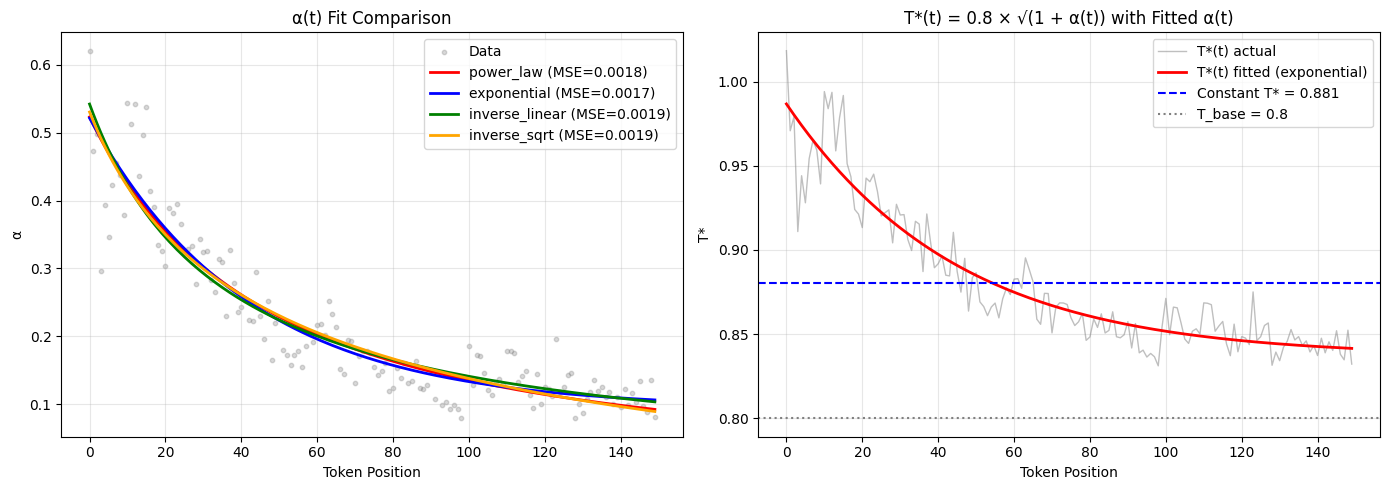


PRACTICAL FORMULA FOR DYNAMIC T*(t)

α(t) ≈ α(t) = 0.4269 × exp(-0.0239×t) + 0.0945

T*(t) = 0.8 × √(1 + α(t))

Or simplified:
T*(t) = 0.8 × √(1 + 0.427×e^(-0.0239×t) + 0.095)


In [13]:
# ============================================================
# PLOT FITTED FUNCTIONS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: All fits comparison
ax1 = axes[0]
ax1.scatter(positions_arr, alpha_arr, alpha=0.3, s=10, color='gray', label='Data')

colors = {'power_law': 'red', 'exponential': 'blue', 'inverse_linear': 'green', 'inverse_sqrt': 'orange'}
for name, fit in fits.items():
    pred = fit['func'](positions_arr, *fit['params'])
    ax1.plot(positions_arr, pred, color=colors.get(name, 'black'), linewidth=2, 
             label=f"{name} (MSE={fit['mse']:.4f})")

ax1.set_xlabel('Token Position')
ax1.set_ylabel('α')
ax1.set_title('α(t) Fit Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Best fit with T*(t)
ax2 = axes[1]
best_pred = best_fit['func'](positions_arr, *best_fit['params'])
t_star_fitted = T_BASE * np.sqrt(1 + best_pred)

ax2.plot(positions_arr, t_star_activation, 'gray', alpha=0.5, linewidth=1, label='T*(t) actual')
ax2.plot(positions_arr, t_star_fitted, 'red', linewidth=2, label=f'T*(t) fitted ({best_name})')
ax2.axhline(y=t_star_const_act, color='blue', linestyle='--', label=f'Constant T* = {t_star_const_act:.3f}')
ax2.axhline(y=T_BASE, color='gray', linestyle=':', label=f'T_base = {T_BASE}')

ax2.set_xlabel('Token Position')
ax2.set_ylabel('T*')
ax2.set_title(f'T*(t) = {T_BASE} × √(1 + α(t)) with Fitted α(t)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('alpha_fit.png', dpi=150)
plt.show()

# Print practical formula
print("\n" + "="*70)
print("PRACTICAL FORMULA FOR DYNAMIC T*(t)")
print("="*70)
print(f"\nα(t) ≈ {fits[best_name]['formula']}")
print(f"\nT*(t) = {T_BASE} × √(1 + α(t))")
print(f"\nOr simplified:")
if best_name == 'exponential':
    a, b, c = best_fit['params']
    print(f"T*(t) = {T_BASE} × √(1 + {a:.3f}×e^(-{b:.4f}×t) + {c:.3f})")
elif best_name == 'inverse_sqrt':
    a, b, c = best_fit['params']
    print(f"T*(t) = {T_BASE} × √(1 + {a:.3f}/√(t+{b:.1f}) + {c:.3f})")


## Summary

In [14]:
# ============================================================
# SUMMARY
# ============================================================

print("="*70)
print("EXPERIMENT 6 SUMMARY: α vs Position")
print("="*70)

print(f"\nConfiguration:")
print(f"  T_base = {T_BASE}")
print(f"  Noise scale = {noise_scale}")
print(f"  Sequence length = {len(alpha_activation)}")

print(f"\nActivation Noise:")
print(f"  α decrease: {ratio_act:.1f}x (first 10 vs last 10)")
print(f"  T*(t) range: {min(t_star_activation):.3f} to {max(t_star_activation):.3f}")
print(f"  Constant T* recommendation: {t_star_const_act:.3f}")

print(f"\nWeight Noise:")
print(f"  α decrease: {ratio_weight:.1f}x (first 10 vs last 10)")
print(f"  T*(t) range: {min(t_star_weight):.3f} to {max(t_star_weight):.3f}")
print(f"  Constant T* recommendation: {t_star_const_weight:.3f}")

print(f"\nKey Findings:")
print(f"  1. α decreases with position (LayerNorm effect)")
print(f"  2. Early tokens need higher T*, late tokens need T* ≈ T_base")
print(f"  3. Constant T* over-corrects late tokens, under-corrects early ones")
print(f"  4. Dynamic T*(t) could improve accuracy but adds complexity")

EXPERIMENT 6 SUMMARY: α vs Position

Configuration:
  T_base = 0.8
  Noise scale = 0.05
  Sequence length = 150

Activation Noise:
  α decrease: 4.0x (first 10 vs last 10)
  T*(t) range: 0.831 to 1.018
  Constant T* recommendation: 0.881

Weight Noise:
  α decrease: 1.2x (first 10 vs last 10)
  T*(t) range: 0.808 to 0.817
  Constant T* recommendation: 0.811

Key Findings:
  1. α decreases with position (LayerNorm effect)
  2. Early tokens need higher T*, late tokens need T* ≈ T_base
  3. Constant T* over-corrects late tokens, under-corrects early ones
  4. Dynamic T*(t) could improve accuracy but adds complexity
